In [1]:
import  os
import  tensorflow as tf
import  numpy as np
from    matplotlib import pyplot as plt

In [2]:
np.random.seed(333)
tf.random.set_seed(333)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.'), "TensorFlow Version Below 2.0"

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train.astype(np.float32)/255., x_test.astype(np.float32)/255.

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


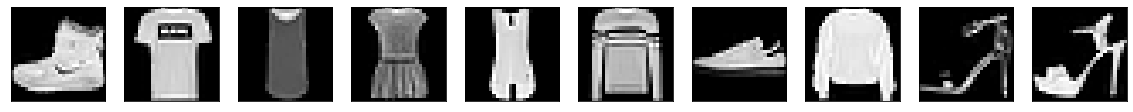

In [4]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_train[index], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [5]:
image_size = x_train.shape[1]*x_train.shape[2]
hidden_dim = 512
latent_dim = 10
num_epochs = 80
batch_size = 100
learning_rate = 0.001

In [6]:
class VAE(tf.keras.Model):

    def __init__(self,dim,**kwargs):
        h_dim = dim[0]
        z_dim = dim[1]
        super(VAE, self).__init__(**kwargs)

        self.fc1 = tf.keras.layers.Dense(h_dim)
        self.fc2 = tf.keras.layers.Dense(z_dim)
        self.fc3 = tf.keras.layers.Dense(z_dim)

        self.fc4 = tf.keras.layers.Dense(h_dim)
        self.fc5 = tf.keras.layers.Dense(image_size)

    def encode(self, x):
        h = tf.nn.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = tf.exp(log_var * 0.5)
        eps = tf.random.normal(std.shape)

        return mu + eps * std

    def decode_logits(self, z):
        h = tf.nn.relu(self.fc4(z))
        return self.fc5(h)

    def decode(self, z):
        return tf.nn.sigmoid(self.decode_logits(z))

    def call(self, inputs, training=None, mask=None):
        mu, log_var = self.encode(inputs)
        z = self.reparameterize(mu, log_var)
        x_reconstructed_logits = self.decode_logits(z)

        return x_reconstructed_logits, mu, log_var

In [7]:
model = VAE([hidden_dim, latent_dim])
model.build(input_shape=(4, image_size))
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate)

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  401920    
                                                                 
 dense_1 (Dense)             multiple                  5130      
                                                                 
 dense_2 (Dense)             multiple                  5130      
                                                                 
 dense_3 (Dense)             multiple                  5632      
                                                                 
 dense_4 (Dense)             multiple                  402192    
                                                                 
Total params: 820,004
Trainable params: 820,004
Non-trainable params: 0
_________________________________________________________________


In [8]:
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(batch_size * 5).batch(batch_size)

num_batches = x_train.shape[0] // batch_size

for epoch in range(num_epochs):

    for step, x in enumerate(dataset):

        x = tf.reshape(x, [-1, image_size])

        with tf.GradientTape() as tape:

            # Forward pass
            x_reconstruction_logits, mu, log_var = model(x)

            # Compute reconstruction loss and kl divergence
            reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_reconstruction_logits)
            reconstruction_loss = tf.reduce_sum(reconstruction_loss) / batch_size
            kl_div = - 0.5 * tf.reduce_sum(1. + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
            kl_div = tf.reduce_mean(kl_div)

            # Backprop and optimize
            loss = tf.reduce_mean(reconstruction_loss) + kl_div

        gradients = tape.gradient(loss, model.trainable_variables)
        for g in gradients:
            tf.clip_by_norm(g, 15)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if (step + 1) % 50 == 0:
            print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                  .format(epoch + 1, num_epochs, step + 1, num_batches, float(reconstruction_loss), float(kl_div)))

Epoch[1/80], Step [50/600], Reconst Loss: 294.8600, KL Div: 14.0198
Epoch[1/80], Step [100/600], Reconst Loss: 291.6082, KL Div: 14.1258
Epoch[1/80], Step [150/600], Reconst Loss: 252.8786, KL Div: 14.9382
Epoch[1/80], Step [200/600], Reconst Loss: 255.8645, KL Div: 12.9271
Epoch[1/80], Step [250/600], Reconst Loss: 254.9722, KL Div: 14.3401
Epoch[1/80], Step [300/600], Reconst Loss: 258.3221, KL Div: 14.7604
Epoch[1/80], Step [350/600], Reconst Loss: 243.8293, KL Div: 15.0483
Epoch[1/80], Step [400/600], Reconst Loss: 240.9897, KL Div: 13.8302
Epoch[1/80], Step [450/600], Reconst Loss: 240.5513, KL Div: 13.5787
Epoch[1/80], Step [500/600], Reconst Loss: 243.6916, KL Div: 13.8394
Epoch[1/80], Step [550/600], Reconst Loss: 240.5745, KL Div: 14.1422
Epoch[1/80], Step [600/600], Reconst Loss: 223.6359, KL Div: 15.4604
Epoch[2/80], Step [50/600], Reconst Loss: 244.9550, KL Div: 14.8179
Epoch[2/80], Step [100/600], Reconst Loss: 229.5184, KL Div: 14.3811
Epoch[2/80], Step [150/600], Reconst

In [9]:
z = tf.random.normal((batch_size, latent_dim))
out = model.decode(z)  # decode with sigmoid
out = tf.reshape(out, [-1, 28, 28]).numpy() * 255
out = out.astype(np.uint8)

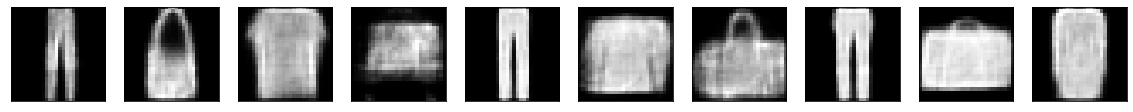

In [10]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(out[index], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()